## TP3 Regresión lineal
Basado en Bishop's PRML. Chapter 3 [https://www.di.fc.ul.pt/~jpn/r/PRML/chapter3.html](https://www.di.fc.ul.pt/~jpn/r/PRML/chapter3.html)  
En esta notebook se definen las funciones desde cero para entender el funcionamiento de las mismas.

In [46]:
import numpy as np
import matplotlib.pyplot as plt

#### Carga de datos

In [47]:
X_all = np.loadtxt("datasets/dataset-1-training-Entradas.txt")
t_all = np.loadtxt("datasets/dataset-1-training-targets.txt")
X_unknown = np.loadtxt("datasets/dataset-1-Entradas.txt")

# Asegurar que sean vectores columna si son 1D
if X_all.ndim == 1:
    X_all = X_all.reshape(-1, 1)
if t_all.ndim == 1:
    t_all = t_all.reshape(-1, 1)
if X_unknown.ndim == 1:
    X_unknown = X_unknown.reshape(-1, 1)

print(f"\nDatos totales: {X_all.shape[0]}")
print(f"Dimensión entrada: {X_all.shape[1]}")
print(f"Dimensión salida: {t_all.shape[1]}")

# Dividir: 400 ajuste (entrenamiento), 100 validación
n_train = 400
X_train = X_all[:n_train]
X_val = X_all[n_train:]
t_train = t_all[:n_train]
t_val = t_all[n_train:]

print(f"\nShape X_train: {X_train.shape}")
print(f"Shape X_val: {X_val.shape}")
print(f"Shape t_train: {t_train.shape}")
print(f"Shape t_val: {t_val.shape}")


Datos totales: 500
Dimensión entrada: 1
Dimensión salida: 1

Shape X_train: (400, 1)
Shape X_val: (100, 1)
Shape t_train: (400, 1)
Shape t_val: (100, 1)


#### 2. Funciones de base

In [48]:
class PolyBasis:
    """Transformación polinómica con normalización"""
    def __init__(self, degree):
        self.degree = degree
        self.X_mean = None
        self.X_std = None
    
    def fit(self, X):
        """Calcula parámetros de normalización"""
        self.X_mean = np.mean(X, axis=0, keepdims=True)
        self.X_std = np.std(X, axis=0, keepdims=True) + 1e-8
        return self
    
    def transform(self, X):
        """Aplica la transformación polinómica: Φ = [1, x, x², ..., x^M]"""
        N = X.shape[0]
        Phi = [np.ones((N, 1))]
        
        # Normalizar
        X_norm = (X - self.X_mean) / self.X_std
        
        # Agregar potencias
        for p in range(1, self.degree + 1):
            Phi.append(X_norm ** p)
        
        result = np.hstack(Phi)
        
        # Verificar
        if np.isnan(result).any() or np.isinf(result).any():
            print(f"WARNING: Phi contiene NaN o Inf!")
        
        return result
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)


class RBFBasis:
    """Transformación con funciones de base radial (RBF)"""
    def __init__(self, M, sigma=None):
        self.M = M  # Número de centros
        self.sigma = sigma
        self.centers = None
    
    def fit(self, X):
        """Selecciona centros y calcula sigma"""
        # Elegir M centros aleatorios del conjunto de entrenamiento
        idx = np.random.choice(len(X), min(self.M, len(X)), replace=False)
        self.centers = X[idx]
        
        # Calcular sigma automáticamente si no se provee
        if self.sigma is None:
            if self.M > 1:
                dists = []
                for i in range(self.M):
                    for j in range(i + 1, self.M):
                        dist = np.linalg.norm(self.centers[i] - self.centers[j])
                        dists.append(dist)
                self.sigma = max(np.mean(dists), 0.1) if len(dists) > 0 else 1.0
            else:
                self.sigma = 1.0
        
        return self
    
    def transform(self, X):
        """Aplica transformación RBF: φ_j(x) = exp(-||x - μ_j||² / (2σ²))"""
        N = X.shape[0]
        Phi = np.ones((N, 1 + self.M))  # Bias + M funciones RBF
        
        for j in range(self.M):
            diff = X - self.centers[j]
            sq_dist = np.sum(diff**2, axis=1, keepdims=True)
            Phi[:, j + 1:j + 2] = np.exp(-sq_dist / (2 * self.sigma**2))
        
        return Phi
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

#### 3. Obtención del vector de coeficientes
$$ \Phi^T \Phi \mathbf{w} = \Phi^T \mathbf{t} $$

In [49]:
def solve_weights(Phi, t, lam=1e-3):
    """
    Resuelve el sistema de ecuaciones normales con regularización:
    (Φ^T Φ + λI) w = Φ^T t
    """
    M = Phi.shape[1]
    
    # Verificar integridad
    if np.isnan(Phi).any() or np.isinf(Phi).any():
        print("ERROR: Phi contiene NaN o Inf")
        return np.zeros((M, t.shape[1]))
    
    # Ecuaciones normales con regularización Ridge
    A = Phi.T @ Phi + lam * np.eye(M)
    b = Phi.T @ t
    
    try:
        w = np.linalg.solve(A, b)
        
        # Verificar solución
        if np.isnan(w).any() or np.isinf(w).any():
            print("WARNING: w contiene NaN o Inf, usando mínimos cuadrados")
            w = np.linalg.lstsq(Phi, t, rcond=None)[0]
        
        return w
    
    except np.linalg.LinAlgError:
        print("ERROR: Matriz singular, usando mínimos cuadrados")
        return np.linalg.lstsq(Phi, t, rcond=None)[0]


def mse(y, t):
    """Calcula el Error Cuadrático Medio"""
    error = (y - t) ** 2
    valid_errors = error[~np.isnan(error)]
    
    if len(valid_errors) == 0:
        return np.nan
    return np.mean(valid_errors)

#### 4. Experimentación con bases polinómicas

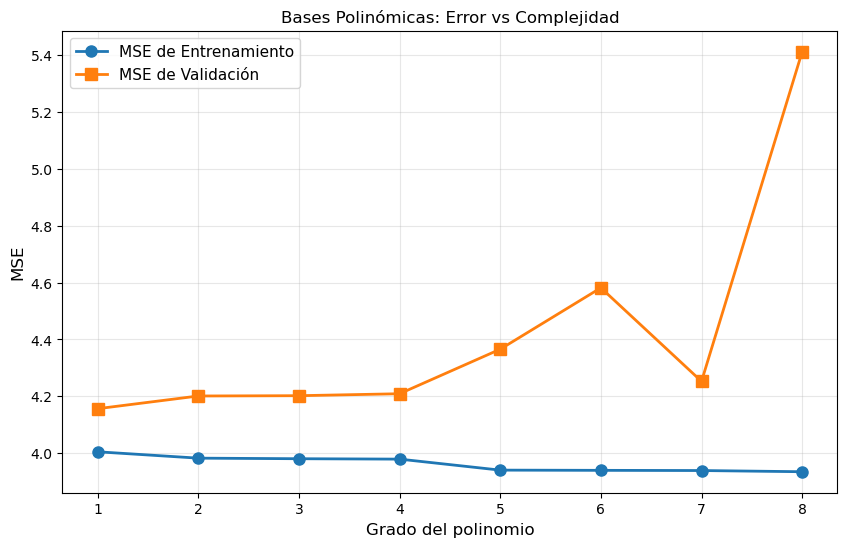

In [50]:
degrees = [1, 2, 3, 4, 5, 6, 7, 8]
train_mse_poly, val_mse_poly = [], []

for deg in degrees:
    # Crear y ajustar la base
    poly_basis = PolyBasis(deg)
    Phi_train = poly_basis.fit_transform(X_train)
    
    # Resolver para obtener w
    w = solve_weights(Phi_train, t_train, lam=1e-3)
    
    # Predicción en entrenamiento: ŷ = Φ w
    y_train = Phi_train @ w
    
    # Transformar validación y predecir
    Phi_val = poly_basis.transform(X_val)
    y_val = Phi_val @ w
    
    # Calcular errores
    mse_train = mse(y_train, t_train)
    mse_val = mse(y_val, t_val)
    
    train_mse_poly.append(mse_train)
    val_mse_poly.append(mse_val)
    
# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mse_poly, 'o-', label="MSE de Entrenamiento", linewidth=2, markersize=8)
plt.plot(degrees, val_mse_poly, 's-', label="MSE de Validación", linewidth=2, markersize=8)
plt.xlabel("Grado del polinomio", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("Bases Polinómicas: Error vs Complejidad", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

#### 5. Experimentación con bases RBF

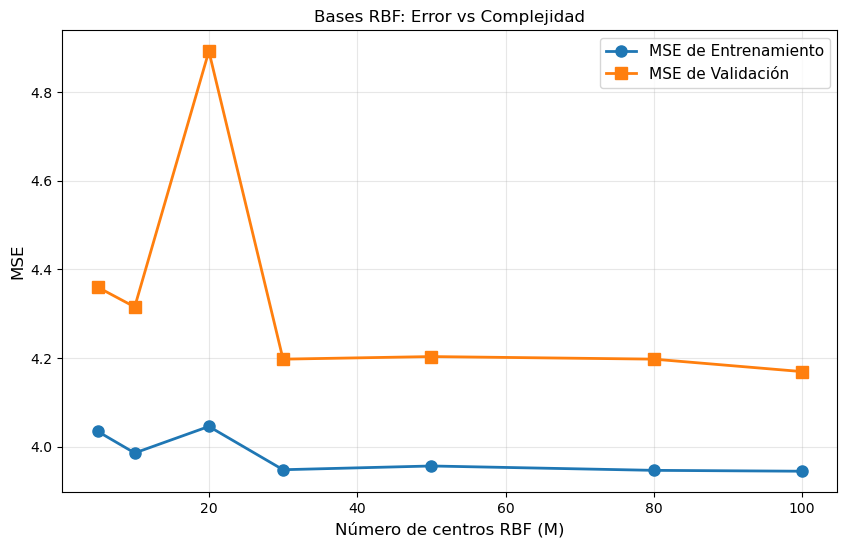

In [51]:
M_list = [5, 10, 20, 30, 50, 80, 100]
train_mse_rbf, val_mse_rbf = [], []

np.random.seed(42)  # Reproducibilidad

for M in M_list:
    # Crear y ajustar la base
    rbf_basis = RBFBasis(M)
    Phi_train = rbf_basis.fit_transform(X_train)
    
    # Resolver para w
    w = solve_weights(Phi_train, t_train, lam=1e-3)
    
    # Predicciones
    y_train = Phi_train @ w
    Phi_val = rbf_basis.transform(X_val)
    y_val = Phi_val @ w
    
    # Errores
    mse_train = mse(y_train, t_train)
    mse_val = mse(y_val, t_val)
    
    train_mse_rbf.append(mse_train)
    val_mse_rbf.append(mse_val)

# Visualizar
plt.figure(figsize=(10, 6))
plt.plot(M_list, train_mse_rbf, 'o-', label="MSE de Entrenamiento", linewidth=2, markersize=8)
plt.plot(M_list, val_mse_rbf, 's-', label="MSE de Validación", linewidth=2, markersize=8)
plt.xlabel("Número de centros RBF (M)", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("Bases RBF: Error vs Complejidad", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

#### 6. Selección del mejor modelo

In [52]:
best_poly_deg = degrees[np.argmin(val_mse_poly)]
best_rbf_M = M_list[np.argmin(val_mse_rbf)]

print(f"\nMejor polinomio: grado {best_poly_deg}")
print(f"  Val MSE = {min(val_mse_poly):.6f}")

print(f"\nMejor RBF: M = {best_rbf_M}")
print(f"  Val MSE = {min(val_mse_rbf):.6f}")

# Elegir el mejor entre ambos
if min(val_mse_poly) <= min(val_mse_rbf):
    chosen = ("poly", best_poly_deg)
    print(f"\n>>> MODELO ELEGIDO: Polinomial grado {best_poly_deg}")
else:
    chosen = ("rbf", best_rbf_M)
    print(f"\n>>> MODELO ELEGIDO: RBF con M = {best_rbf_M}")


Mejor polinomio: grado 1
  Val MSE = 4.156466

Mejor RBF: M = 100
  Val MSE = 4.169055

>>> MODELO ELEGIDO: Polinomial grado 1


#### 7. Entrenamiento final y predicción en datos desconocidos

In [53]:
np.random.seed(42)

if chosen[0] == "poly":
    basis = PolyBasis(chosen[1])
    Phi_all = basis.fit_transform(X_all)
    w_final = solve_weights(Phi_all, t_all, lam=1e-3)
    Phi_unknown = basis.transform(X_unknown)
else:
    basis = RBFBasis(chosen[1])
    Phi_all = basis.fit_transform(X_all)
    w_final = solve_weights(Phi_all, t_all, lam=1e-3)
    Phi_unknown = basis.transform(X_unknown)

# Predicción: ŷ = w^T Φ(x)
y_unknown = Phi_unknown @ w_final

print(f"\nPredicciones calculadas: {y_unknown.shape[0]} ejemplos")
print(f"Primeras 5 predicciones:\n{y_unknown[:5].flatten()}")

# Guardar predicciones
np.savetxt("predicciones_unknown.txt", y_unknown, fmt="%.6f")
print("\n✓ Predicciones guardadas en 'predicciones_unknown.txt'")


Predicciones calculadas: 500 ejemplos
Primeras 5 predicciones:
[-6.1187953  -5.18946053 -4.60852145 -4.23155708 -4.00328116]

✓ Predicciones guardadas en 'predicciones_unknown.txt'


#### 8. Análisis de residuos y distribución predictiva


Media de residuos: -0.000000
Desviación estándar: 2.004211
Residuo mínimo: -5.398351
Residuo máximo: 5.995164

Varianza del ruido estimada: σ² = 4.016861


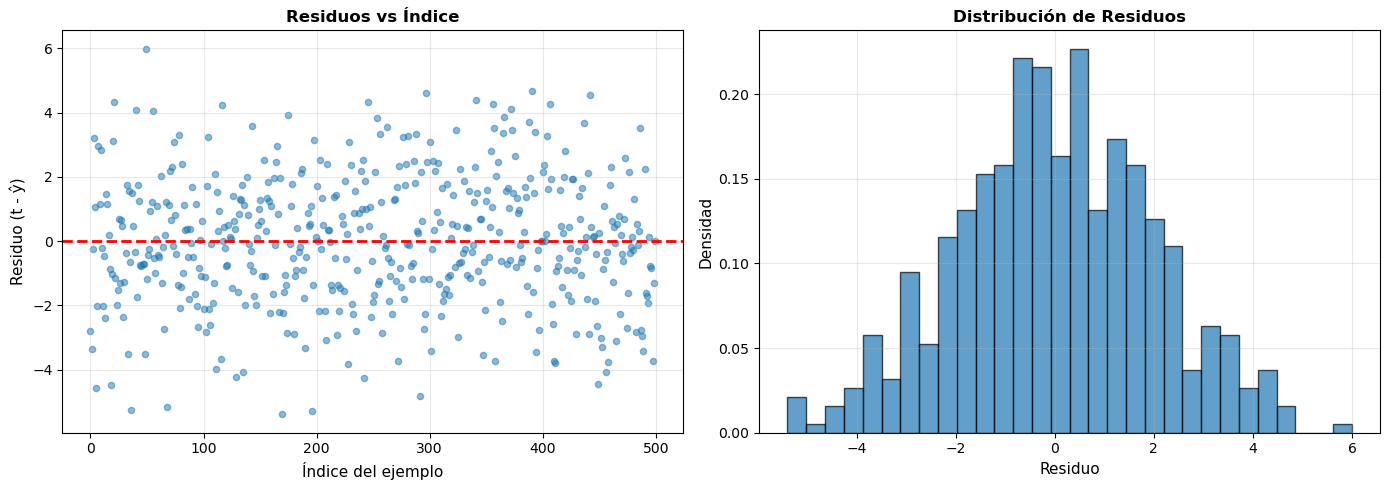

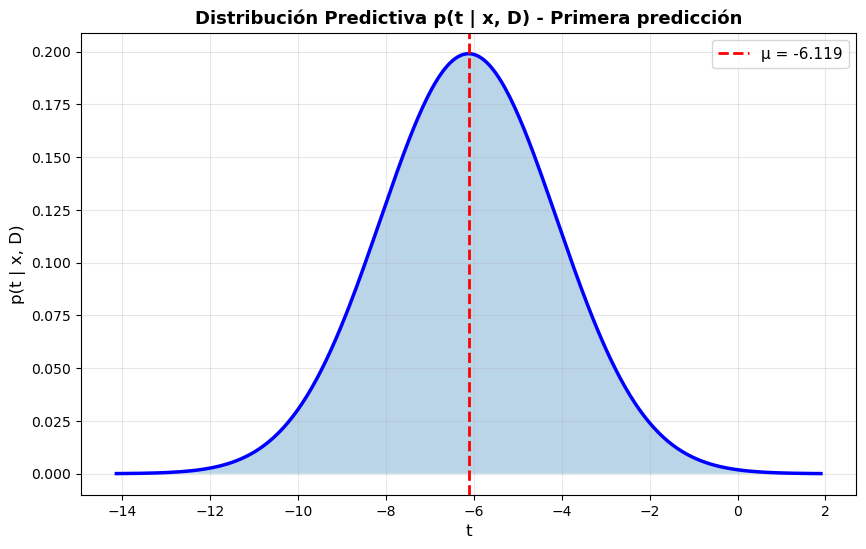

In [54]:
# Calcular residuos en todos los datos
y_all = Phi_all @ w_final
residuals = t_all - y_all

# Estadísticas
print(f"\nMedia de residuos: {np.mean(residuals):.6f}")
print(f"Desviación estándar: {np.std(residuals):.6f}")
print(f"Residuo mínimo: {np.min(residuals):.6f}")
print(f"Residuo máximo: {np.max(residuals):.6f}")

# Estimar varianza del ruido
sigma2 = np.var(residuals)
print(f"\nVarianza del ruido estimada: σ² = {sigma2:.6f}")

# Visualizar residuos
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(range(len(residuals)), residuals, alpha=0.5, s=20)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Índice del ejemplo", fontsize=11)
plt.ylabel("Residuo (t - ŷ)", fontsize=11)
plt.title("Residuos vs Índice", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
plt.xlabel("Residuo", fontsize=11)
plt.ylabel("Densidad", fontsize=11)
plt.title("Distribución de Residuos", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribución predictiva para la primera predicción desconocida
if sigma2 > 0 and not np.isnan(sigma2):
    mu = y_unknown[0, 0]
    std = np.sqrt(sigma2)
    
    plt.figure(figsize=(10, 6))
    xs = np.linspace(mu - 4*std, mu + 4*std, 300)
    pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu) / std)**2)
    
    plt.plot(xs, pdf, linewidth=2.5, color='blue')
    plt.axvline(mu, color='red', linestyle='--', linewidth=2, label=f'μ = {mu:.3f}')
    plt.fill_between(xs, pdf, alpha=0.3)
    
    plt.xlabel("t", fontsize=12)
    plt.ylabel("p(t | x, D)", fontsize=12)
    plt.title("Distribución Predictiva p(t | x, D) - Primera predicción", 
              fontsize=13, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()